# Praca domowa 7

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.mixture import GaussianMixture
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.decomposition import PCA

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/gekas145/2021L-WUM/main/Prace_domowe/Praca_domowa7/train.csv")
val = pd.read_csv("https://raw.githubusercontent.com/gekas145/2021L-WUM/main/Prace_domowe/Praca_domowa7/val.csv")
test = pd.read_csv("https://raw.githubusercontent.com/gekas145/2021L-WUM/main/Prace_domowe/Praca_domowa7/test.csv")

## Eksploracja

In [6]:
data = pd.concat([train, val, test.drop("class", axis=1)])
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,12.72,1.75,2.28,22.5,84,1.38,1.76,0.48,1.63,3.30,0.88,2.42,488
1,13.23,3.30,2.28,18.5,98,1.80,0.83,0.61,1.87,10.52,0.56,1.51,675
2,12.58,1.29,2.10,20.0,103,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640
3,12.37,1.17,1.92,19.6,78,2.11,2.00,0.27,1.04,4.68,1.12,3.48,510
4,13.84,4.12,2.38,19.5,89,1.80,0.83,0.48,1.56,9.01,0.57,1.64,480


In [7]:
data.info()
# nie ma braków

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 16
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Alcohol                       129 non-null    float64
 1   Malic acid                    129 non-null    float64
 2   Ash                           129 non-null    float64
 3   Alcalinity of ash             129 non-null    float64
 4   Magnesium                     129 non-null    int64  
 5   Total phenols                 129 non-null    float64
 6   Flavanoids                    129 non-null    float64
 7   Nonflavanoid phenols          129 non-null    float64
 8   Proanthocyanins               129 non-null    float64
 9   Color intensity               129 non-null    float64
 10  Hue                           129 non-null    float64
 11  OD280/OD315 of diluted wines  129 non-null    float64
 12  Proline                       129 non-null    int64  
dtypes: flo

In [115]:
data.describe() # wszystkie cechy wyglądają na ciągłę

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,12.730078,2.434496,2.327984,20.383721,96.906977,2.094031,1.676357,0.388217,1.475504,4.880388,0.918496,2.409690,603.565891
std,0.754757,1.219836,0.280071,3.230586,14.443555,0.589130,0.928411,0.130507,0.581179,2.594024,0.248000,0.707028,206.534419
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.210000,1.510000,2.200000,18.500000,87.000000,1.630000,0.800000,0.270000,1.040000,2.850000,0.720000,1.750000,465.000000
50%,12.640000,2.050000,2.320000,20.000000,94.000000,2.000000,1.590000,0.400000,1.420000,4.000000,0.910000,2.440000,564.000000
75%,13.320000,3.270000,2.500000,22.000000,103.000000,2.530000,2.260000,0.480000,1.830000,6.380000,1.080000,3.070000,685.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.520000,5.080000,0.660000,3.580000,13.000000,1.710000,3.820000,1515.000000


## Wykrywanie obserwacji odstających

In [19]:
bic_score = [0] * 10
for i in range(10):
    gmm = GaussianMixture(n_components=i+1, random_state=42)
    gmm.fit(train)
    bic_score[i] = gmm.bic(train)
bic_score
# Wybieramy liczbę komponentów o najmniejszym BIC(Bayesian Information Criterion), czyli 1

[3902.044526130818,
 4130.146286117928,
 4236.715680753536,
 4304.580333352633,
 4511.176320765673,
 4718.655633319111,
 4314.5034242540105,
 4580.929864696952,
 4175.578326115064,
 4148.519500039201]

In [48]:
gmm = GaussianMixture(n_components=1, random_state=42)
gmm.fit(train)
scores_train = gmm.score_samples(train)
scores_val = gmm.score_samples(val)

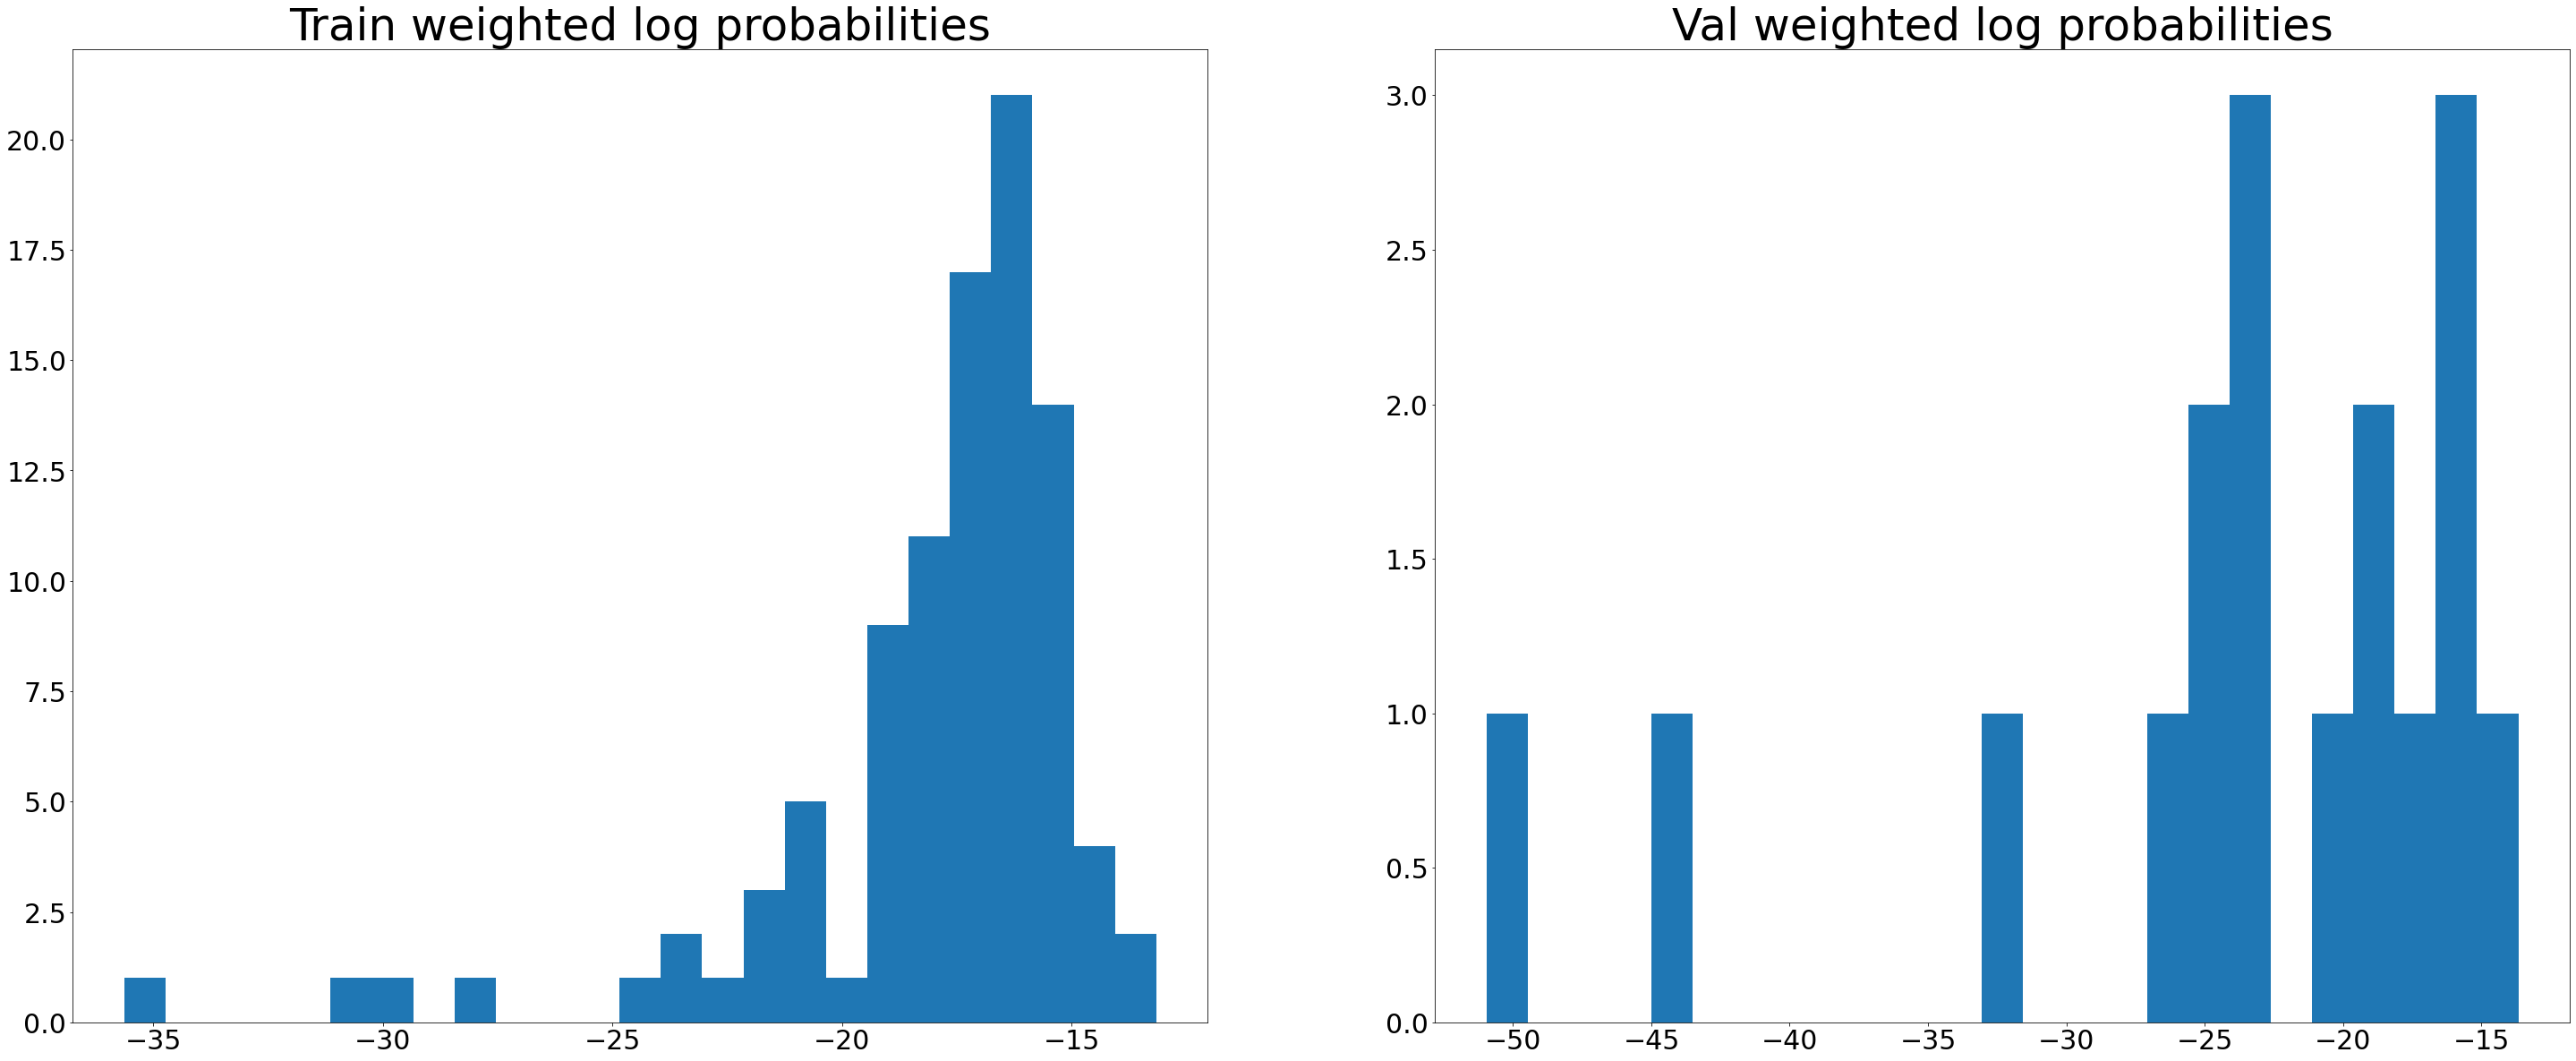

Minimalna wartość w zbiorze treningowym: -35.63


In [114]:
# Teraz szukamy dobrego punktu odcięcia, 
# obserwacje o log prawdopodobieństwach poniżej którego będą uznawane za odstające
fig, axes = plt.subplots(1, 2, figsize=(50,20))
axes[0].hist(scores_train, bins=25)
axes[0].tick_params(labelsize=30)
axes[0].set_title("Train weighted log probabilities", fontsize=50)

axes[1].hist(scores_val, bins=25)
axes[1].tick_params(labelsize=30)
axes[1].set_title("Val weighted log probabilities", fontsize=50)

plt.show()
print(f"Minimalna wartość w zbiorze treningowym: {np.min(scores_train):.2f}")
# zakładając, że w zbiorze treningowym nie ma outlierów
# jako dobry punkt odciędia prezentuje się -32 lub -36(wtedy wszystkie obserwacje z train są inlierami)

In [70]:
scores_test = np.array(gmm.score_samples(test.drop("class", axis=1)))
thresholds = [-32, -36]
predict = lambda x: np.array(x <= threshold, dtype=int)
pred = [0] * 2
for i in range(len(thresholds)):
    threshold = thresholds[i]
    predict = lambda x: np.array(x <= threshold, dtype=int)
    pred[i] = predict(scores_test)

In [86]:
def get_metrics(true, pred, thresholds):
    metrics = {}
    for i in range(len(thresholds)):
        metrics[i] = [thresholds[i],
                      f1_score(true, pred[i]),
                      precision_score(true, pred[i]), 
                      recall_score(true, pred[i])]
    return pd.DataFrame.from_dict(metrics, 
                                  orient="index", 
                                  columns=["threshold", "f1_score", "precision", "recall"])

In [87]:
get_metrics(test["class"], pred, thresholds)
# jak można było się spodziewać,
# większy threshold za outliery uznaje tylko outliery(wysoki precision),
# ale niektóre outliery nie rozpoznaje(nie najlepszy recall) 
# i odwrotnie z mniejszym thresholdem,
# threshold=-32 dał większy f1_score, więc może być uznany za lepszy wybór

,threshold,f1_score,precision,recall
0,-32,0.909091,0.833333,1.0
1,-36,0.750000,1.000000,0.6


In [101]:
pca = PCA(n_components=2, random_state=42)
test_pca = pca.fit_transform(test.drop("class", axis=1))
pca.explained_variance_ratio_
# skoro pierwsze 2 komponenty tłumaczą tak dużo wariancji,
# można spróbować zrobić wizualizację obserwacji w 2D,
# zrobimy to za pomocą PCA, bowiem zachowuje ten algorytm duże dystansy pomiędzy obserwacjami,
# zwłaszcza, gdy pierwszy komponenty tłumaczy sporą część wariancji

array([0.99633363, 0.00354652])

In [94]:
def reshape(components):
    res = np.zeros((2, components.shape[0]))
    for i in range(len(components)):
        res[0][i] = components[i][0]
        res[1][i] = components[i][1]
    return res

In [ ]:
test_pca = reshape(test_pca)

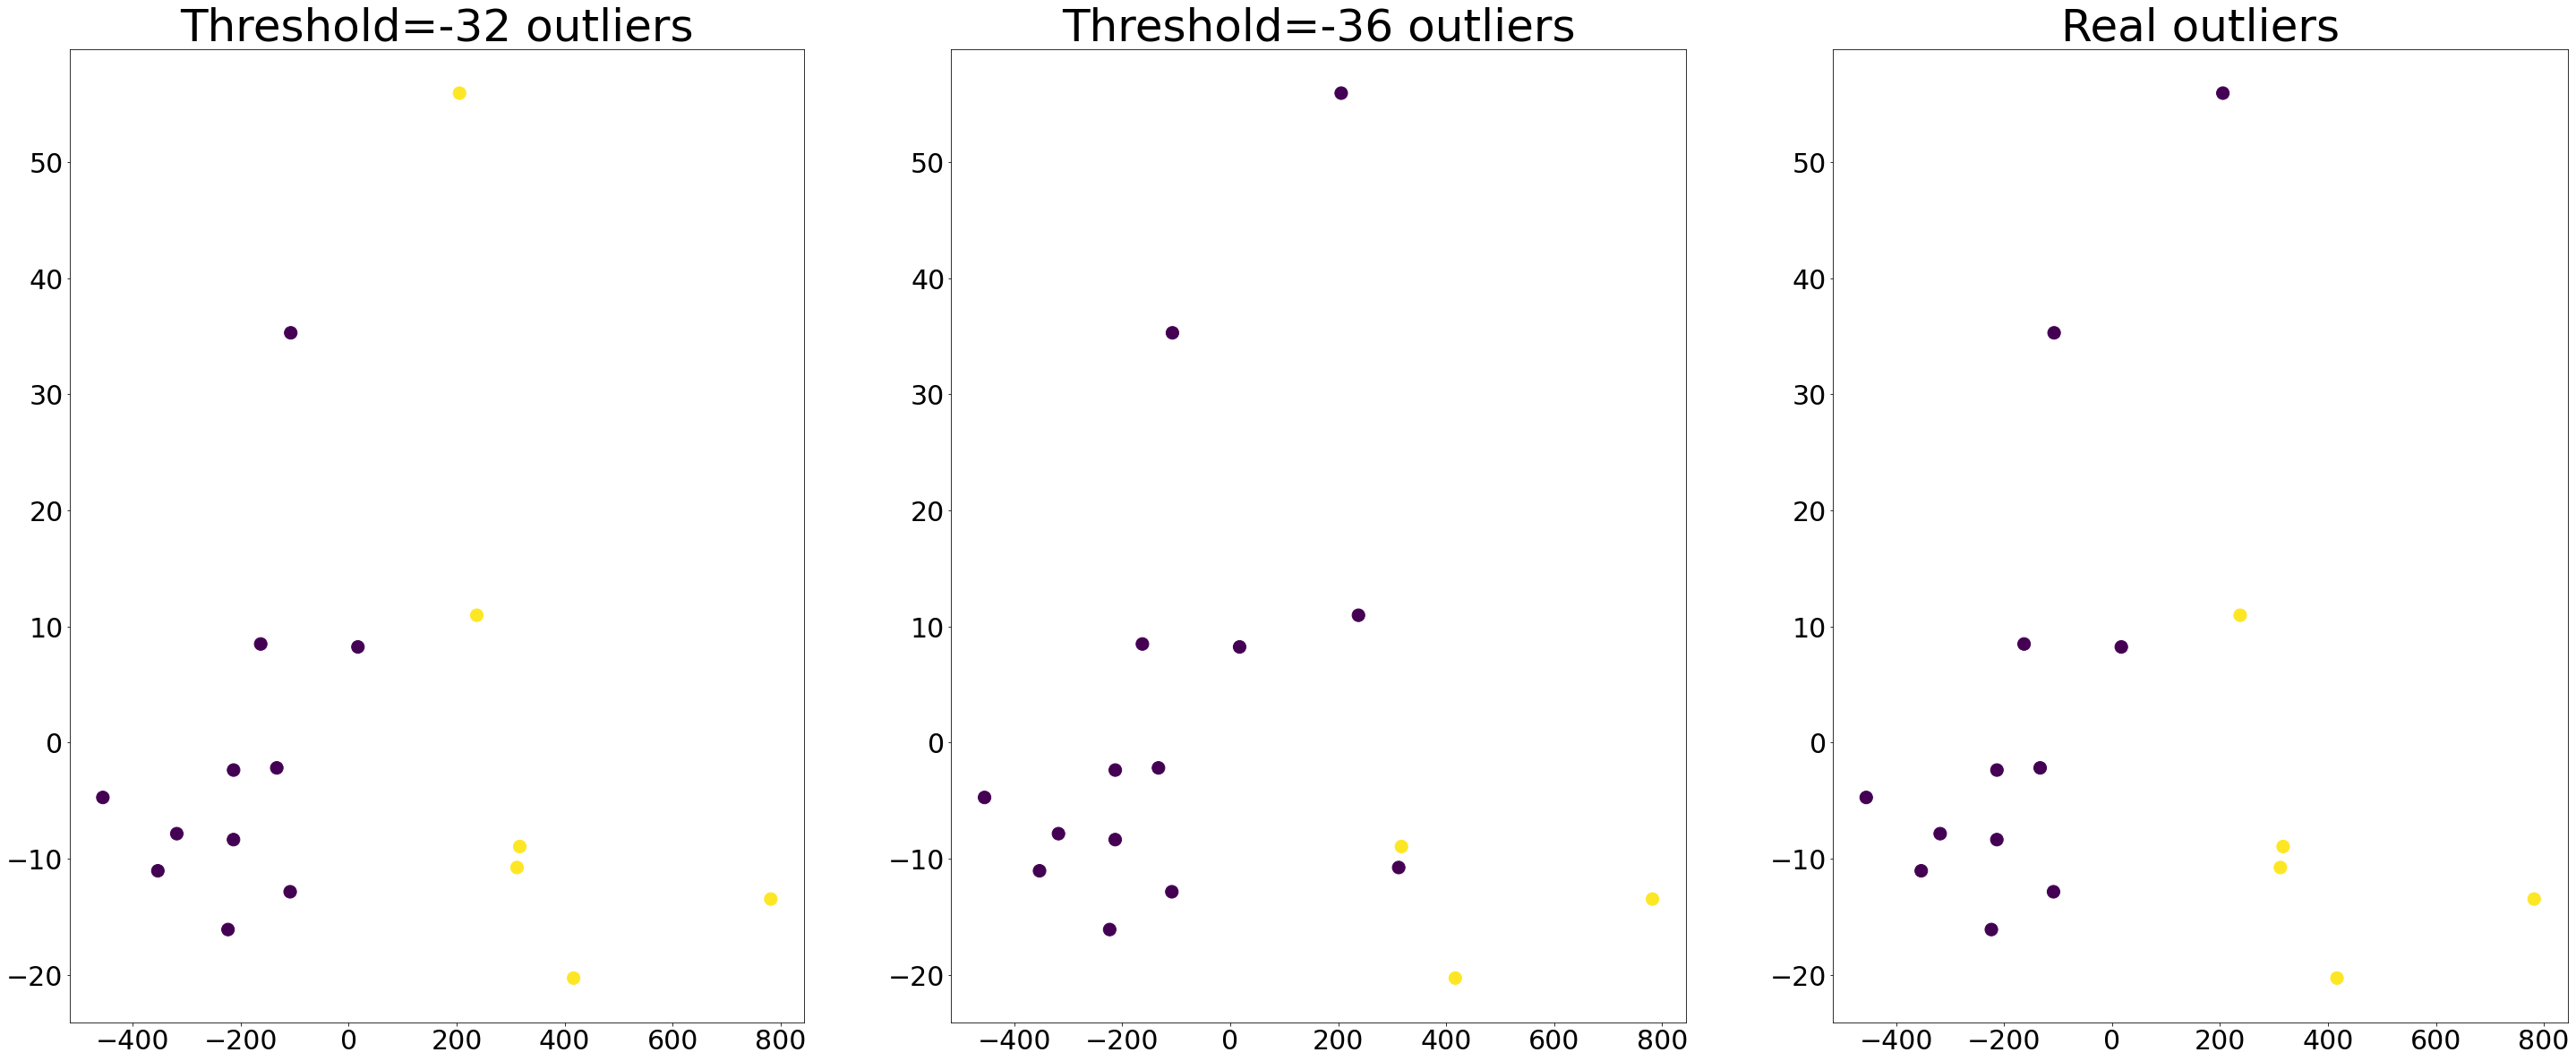

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(50,20))
axes[0].scatter(test_pca[0], test_pca[1], s=200, c=pred[0])
axes[0].tick_params(labelsize=30)
axes[0].set_title("Threshold=-32 outliers", fontsize=50)

axes[1].scatter(test_pca[0], test_pca[1], s=200, c=pred[1])
axes[1].tick_params(labelsize=30)
axes[1].set_title("Threshold=-36 outliers", fontsize=50)

axes[2].scatter(test_pca[0], test_pca[1], s=200, c=test["class"])
axes[2].tick_params(labelsize=30)
axes[2].set_title("Real outliers", fontsize=50)

plt.show()
# Tu można jeszcze raz się przekonać, że obydwaj thresholdy poradziły sobie w miarę dobrze

## Podsumowanie
Otóż GMM z pewnością da się stosować do wykrywania obserwacji odstających, czasem(jak wyżej) nawet nie stosując żadnego preprocessingu, jedynym problemem może wtedy być otrzymanie treningowego zbioru danych bez outierów.